In [62]:
!pip install torchsummary

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torchsummary import summary
from utils import train, plot_results, display_dataset, train_long, check_image_dir

%matplotlib inline

In [5]:
data_dir = "/dgx/code/data/tomato_v2"
train_dir = data_dir + "/train"
valid_dir = data_dir + "/val"
diseases = os.listdir(train_dir)

In [6]:
diseases

['powdery_mildew-うどんこ病',
 'yellow_leaf_curl-黄化葉巻病',
 'cercospora_leaf_mold-すすかび病',
 'target_spot-褐色輪紋病',
 'leaf_mold-葉かび病',
 'healthy-健全',
 'late_blight-疫病']

In [7]:
nums = {}
for disease in diseases:
    directory = train_dir + '/' + disease
    nums[disease] = len(os.listdir(directory))
    check_image_dir(f'{directory}/*.jpg')

In [8]:
img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

,no. of images
powdery_mildew-うどんこ病,982
yellow_leaf_curl-黄化葉巻病,1000
cercospora_leaf_mold-すすかび病,225
target_spot-褐色輪紋病,1000
leaf_mold-葉かび病,1000
healthy-健全,1000
late_blight-疫病,1000


In [48]:
trans = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [49]:
train_set = ImageFolder(train_dir, transform=trans)
valid_set = ImageFolder(valid_dir, transform=trans) 

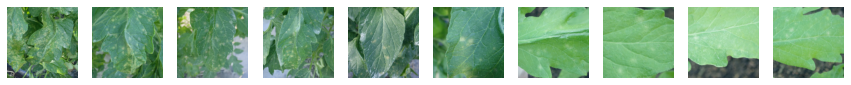

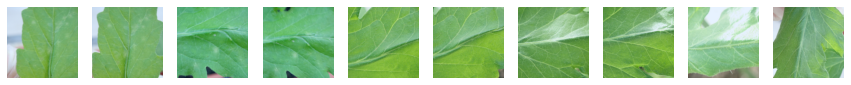

In [31]:
display_dataset(train_set)
display_dataset(valid_set)

In [32]:
img, label = train_set[0]
print(img.shape, label)

torch.Size([3, 256, 256]) 0


In [33]:
len(train_set.classes)

7

In [34]:
def show_image(image, label):
    print("Label: " + train_set.classes[label] + "(" + str(label) + ")")
    plt.imshow(image.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: cercospora_leaf_mold-すすかび病(0)


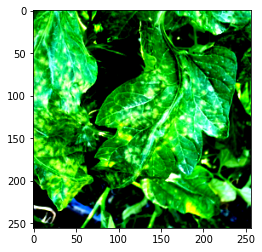

In [35]:
show_image(*train_set[0])

In [36]:
random_seed = 7
torch.manual_seed(random_seed)

In [37]:
batch_size = 32

In [38]:
train_dl = DataLoader(train_set, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_set, batch_size, num_workers=2, pin_memory=True)

In [39]:
def show_batch(data):
    for images, labels in data:
        fig, ax = plt.subplots(figsize=(30,30))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break
        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


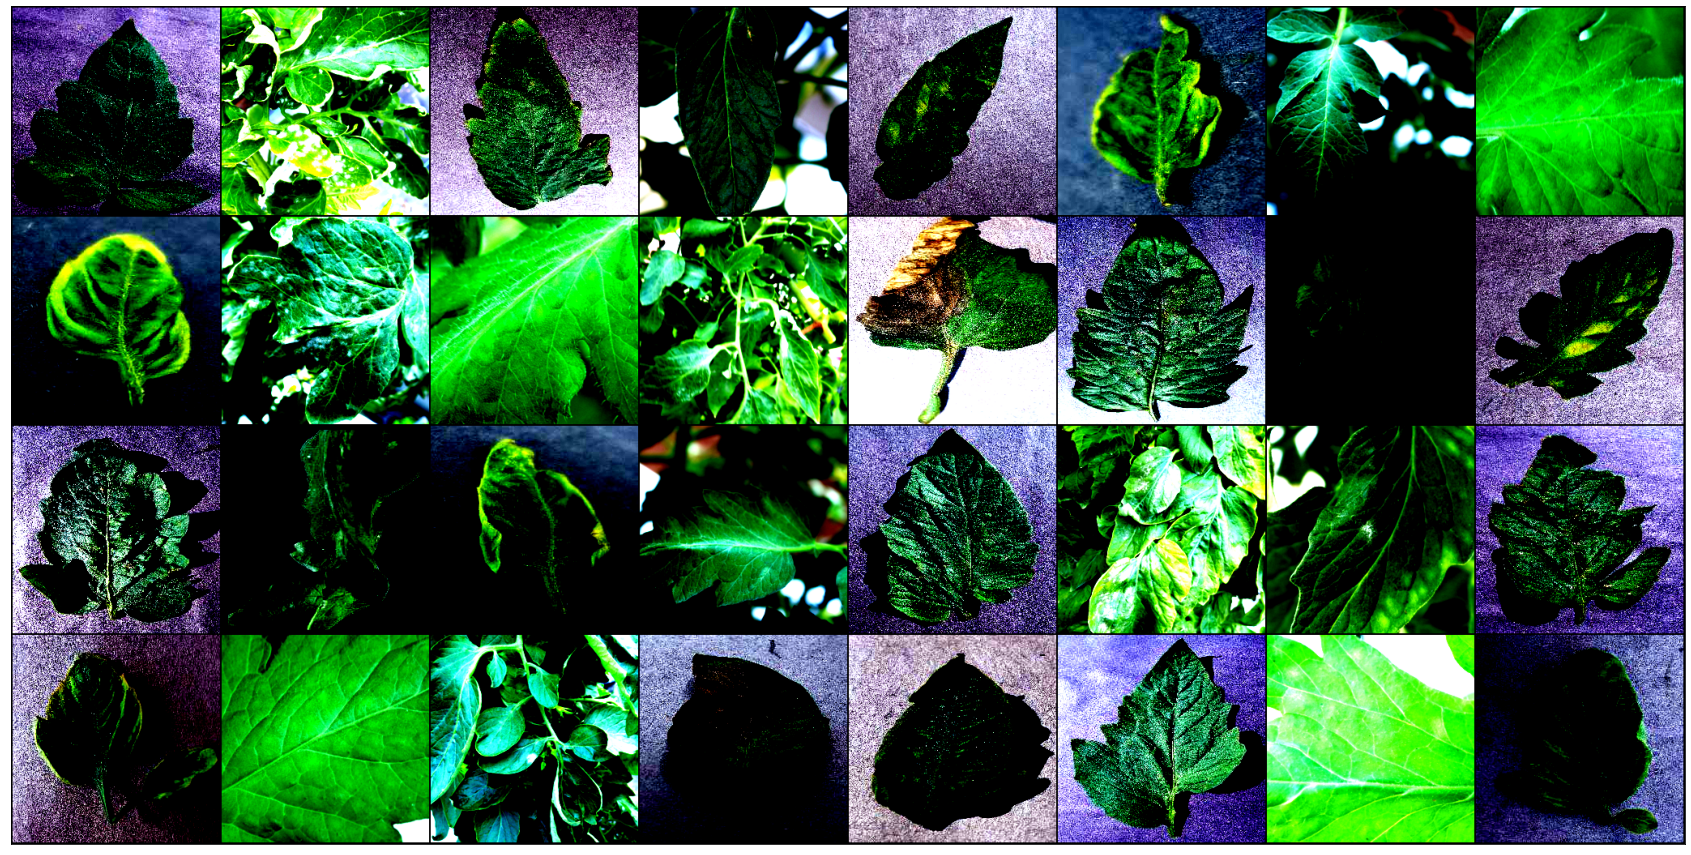

In [40]:
show_batch(train_dl)

In [51]:
def get_default_device():
    if torch.cuda.is_available:
        return torch.device("cuda")
    else:
        return torch.device("cpu")

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
        
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [52]:
device = get_default_device()
device

device(type='cuda')

In [43]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [44]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x # ReLU can be applied before or after adding the input

In [44]:
# for calculating the accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


# base class for the model
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                   # Generate prediction
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)          # Calculate accuracy
        return {"val_loss": loss.detach(), "val_accuracy": acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine loss  
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy} # Combine accuracies
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))

In [45]:
# Architecture for training

# convolution block with BatchNormalization
def ConvBlock(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
             nn.BatchNorm2d(out_channels),
             nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)


# resnet architecture 
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_diseases):
        super().__init__()
        
        self.conv1 = ConvBlock(in_channels, 64)
        self.conv2 = ConvBlock(64, 128, pool=True) # out_dim : 128 x 64 x 64 
        self.res1 = nn.Sequential(ConvBlock(128, 128), ConvBlock(128, 128))
        
        self.conv3 = ConvBlock(128, 256, pool=True) # out_dim : 256 x 16 x 16
        self.conv4 = ConvBlock(256, 512, pool=True) # out_dim : 512 x 4 x 44
        self.res2 = nn.Sequential(ConvBlock(512, 512), ConvBlock(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                       nn.Flatten(),
                                       nn.Linear(512, num_diseases))
        
    def forward(self, xb): # xb is the loaded batch
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out      

In [47]:
# defining the model and moving it to the GPU
model = to_device(ResNet9(3, len(train_set.classes)), device) 
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [48]:
# getting summary of the model
INPUT_SHAPE = (3, 256, 256)
print(summary(model.cuda(), (INPUT_SHAPE)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4        [-1, 128, 256, 256]          73,856
       BatchNorm2d-5        [-1, 128, 256, 256]             256
              ReLU-6        [-1, 128, 256, 256]               0
         MaxPool2d-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
       BatchNorm2d-9          [-1, 128, 64, 64]             256
             ReLU-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]         147,584
      BatchNorm2d-12          [-1, 128, 64, 64]             256
             ReLU-13          [-1, 128, 64, 64]               0
           Conv2d-14          [-1, 256,

In [49]:
# for training
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    

def fit_OneCycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0,
                grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # scheduler for one cycle learniing rate
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            optimizer.step()
            optimizer.zero_grad()
            
            # recording and updating learning rates
            lrs.append(get_lr(optimizer))
            sched.step()
            
    
        # validation
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        
    return history

In [50]:
%%time
history = [evaluate(model, valid_dl)]
history

CPU times: user 762 ms, sys: 625 ms, total: 1.39 s
Wall time: 6.91 s


[{'val_loss': tensor(1.9439, device='cuda:0'), 'val_accuracy': tensor(0.1473)}]

In [53]:
epochs = 50
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [54]:
%%time
history += fit_OneCycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=1e-4, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00050, train_loss: 0.1171, val_loss: 0.4747, val_acc: 0.8720
Epoch [1], last_lr: 0.00081, train_loss: 0.0882, val_loss: 0.5696, val_acc: 0.8393
Epoch [2], last_lr: 0.00131, train_loss: 0.1391, val_loss: 0.3591, val_acc: 0.8795
Epoch [3], last_lr: 0.00199, train_loss: 0.1611, val_loss: 0.6593, val_acc: 0.8571
Epoch [4], last_lr: 0.00280, train_loss: 0.2117, val_loss: 0.9909, val_acc: 0.8175
Epoch [5], last_lr: 0.00371, train_loss: 0.2747, val_loss: 0.9469, val_acc: 0.8557
Epoch [6], last_lr: 0.00470, train_loss: 0.2451, val_loss: 0.8365, val_acc: 0.8378
Epoch [7], last_lr: 0.00570, train_loss: 0.2469, val_loss: 0.7038, val_acc: 0.8373
Epoch [8], last_lr: 0.00668, train_loss: 0.2601, val_loss: 0.6044, val_acc: 0.8750
Epoch [9], last_lr: 0.00760, train_loss: 0.2361, val_loss: 0.7675, val_acc: 0.8408
Epoch [10], last_lr: 0.00841, train_loss: 0.2384, val_loss: 1.1298, val_acc: 0.7331
Epoch [11], last_lr: 0.00908, train_loss: 0.1780, val_loss: 1.1214, val_acc: 0.7490
Ep

In [55]:
def plot_accuracies(history):
    accuracies = [x['val_accuracy'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

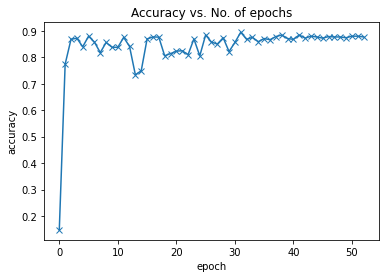

In [56]:
plot_accuracies(history)

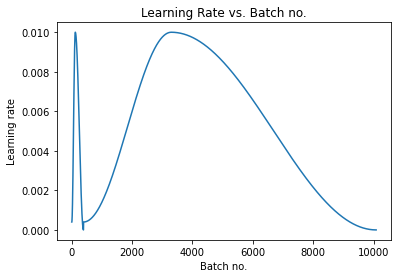

In [60]:
plot_lrs(history)

In [37]:
PATH = './plant-disease-model.pth'  
torch.save(model.state_dict(), PATH)

NameError: name 'model' is not defined

In [77]:
PATH = './plant-disease-model-complete.pth'
torch.save(model, PATH)

## ONNX

In [75]:
import torch.onnx 

def Convert_ONNX(): 

    # set the model to inference mode 
    model.eval() 

    # Let's create a dummy input tensor  
    dummy_input = torch.randn(batch_size, 3, 256, 256, requires_grad=True)  
    dummy_input = dummy_input.cuda()

    # Export the model   
    torch.onnx.export(model,
         dummy_input,
         "plant-disease-classifier.onnx",
         export_params=True,  # store the trained parameter weights inside the model file 
         opset_version=10,    # the ONNX version to export the model to 
         do_constant_folding=True  # whether to execute constant folding for optimization 
    )
    print(" ") 
    print('Model has been converted to ONNX') 

In [76]:
Convert_ONNX()

 
Model has been converted to ONNX


In [73]:
PATH = './plant-disease-model.pth'
model = to_device(ResNet9(3, len(train_set.classes)), device)

In [74]:
model.load_state_dict(torch.load(PATH))
model.eval()

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [116]:
trans2 = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [117]:
test_dir = data_dir + "/test"
test_set = ImageFolder(test_dir, transform=trans2)
test_set.classes

['cercospora_leaf_mold-すすかび病',
 'healthy-健全',
 'late_blight-疫病',
 'leaf_mold-葉かび病',
 'powdery_mildew-うどんこ病',
 'target_spot-褐色輪紋病',
 'yellow_leaf_curl-黄化葉巻病']

In [118]:
test_images = sorted(os.listdir(test_dir)) # since images in test folder are in alphabetical order
test_images

['cercospora_leaf_mold-すすかび病',
 'healthy-健全',
 'late_blight-疫病',
 'leaf_mold-葉かび病',
 'powdery_mildew-うどんこ病',
 'target_spot-褐色輪紋病',
 'yellow_leaf_curl-黄化葉巻病']

In [119]:
def predict_image(img, model):
    """Converts image to array and return the predicted class
        with highest probability"""
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label

    return train_set.classes[preds[0].item()]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: cercospora_leaf_mold-すすかび病 , Predicted: cercospora_leaf_mold-すすかび病


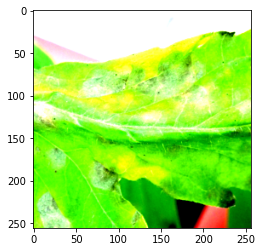

In [120]:
# predicting first image
img, label = test_set[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_images[0], ', Predicted:', predict_image(img, model))

In [124]:
# getting all predictions (actual label vs predicted)
for i, (img, label) in enumerate(test_set):
    print('Label:', test_images[label], ', Predicted:', predict_image(img, model))

Label: cercospora_leaf_mold-すすかび病 , Predicted: cercospora_leaf_mold-すすかび病
Label: cercospora_leaf_mold-すすかび病 , Predicted: cercospora_leaf_mold-すすかび病
Label: cercospora_leaf_mold-すすかび病 , Predicted: cercospora_leaf_mold-すすかび病
Label: healthy-健全 , Predicted: healthy-健全
Label: healthy-健全 , Predicted: healthy-健全
Label: healthy-健全 , Predicted: healthy-健全
Label: late_blight-疫病 , Predicted: late_blight-疫病
Label: late_blight-疫病 , Predicted: late_blight-疫病
Label: late_blight-疫病 , Predicted: late_blight-疫病
Label: leaf_mold-葉かび病 , Predicted: healthy-健全
Label: leaf_mold-葉かび病 , Predicted: healthy-健全
Label: leaf_mold-葉かび病 , Predicted: healthy-健全
Label: powdery_mildew-うどんこ病 , Predicted: powdery_mildew-うどんこ病
Label: powdery_mildew-うどんこ病 , Predicted: powdery_mildew-うどんこ病
Label: powdery_mildew-うどんこ病 , Predicted: powdery_mildew-うどんこ病
Label: target_spot-褐色輪紋病 , Predicted: target_spot-褐色輪紋病
Label: target_spot-褐色輪紋病 , Predicted: target_spot-褐色輪紋病
Label: target_spot-褐色輪紋病 , Predicted: target_spot-褐色輪紋